In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [211]:
#Load dataset
df =pd.read_csv("exchange_rate.csv")
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [213]:
# Basic statistics
df.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


In [214]:
#Checking missing values
df.isnull().sum()

date       0
Ex_rate    0
dtype: int64

<Axes: >

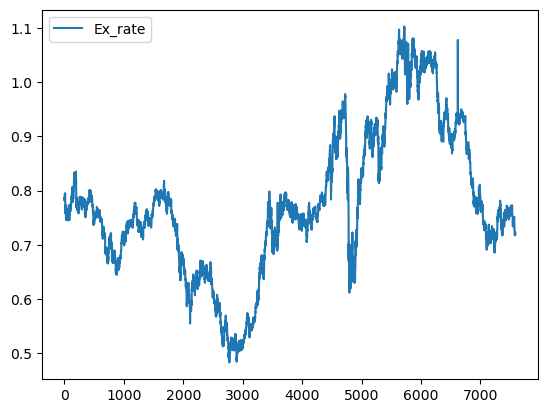

In [215]:
# line plot
df.plot()

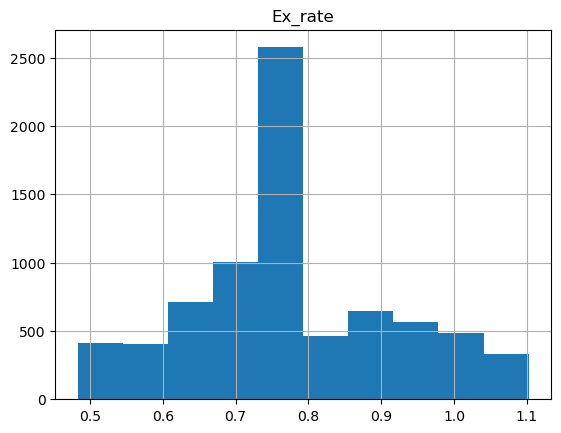

In [216]:
# create a histogram plot
df.hist()
plt.show()

In [217]:
#Extract only year
df['year'] = pd.to_datetime(df['date'], format="%d-%m-%Y %H:%M").dt.year

In [218]:
#Extract only month
df['month'] = pd.to_datetime(df['date'], format="%d-%m-%Y %H:%M").dt.month
df.head()

,date,Ex_rate,year,month
0,01-01-1990 00:00,0.7855,1990,1
1,02-01-1990 00:00,0.7818,1990,1
2,03-01-1990 00:00,0.7867,1990,1
3,04-01-1990 00:00,0.7860,1990,1
4,05-01-1990 00:00,0.7849,1990,1


In [219]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df.set_index('date', inplace=True)

df.head()

,Ex_rate,year,month
date,,,
1990-01-01,0.7855,1990,1
1990-01-02,0.7818,1990,1
1990-01-03,0.7867,1990,1
1990-01-04,0.7860,1990,1
1990-01-05,0.7849,1990,1


In [220]:
#treating Anomaly
window = 30  # 1-month rolling window

Q1 = df['Ex_rate'].rolling(window).quantile(0.25)
Q3 = df['Ex_rate'].rolling(window).quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Cap anomalies instead of removing
df['Ex_rate_clean'] = df['Ex_rate'].clip(lower, upper)


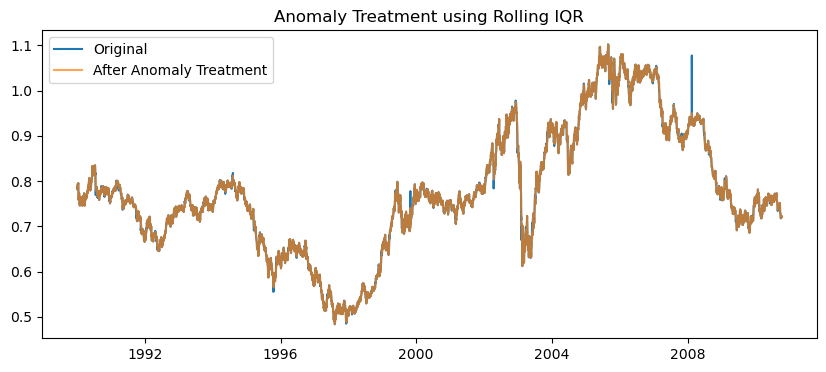

In [221]:
#Visualization of treating Anomaly
plt.figure(figsize=(10,4))
plt.plot(df['Ex_rate'], label='Original')
plt.plot(df['Ex_rate_clean'], label='After Anomaly Treatment', alpha=0.7)
plt.legend()
plt.title("Anomaly Treatment using Rolling IQR")
plt.show()


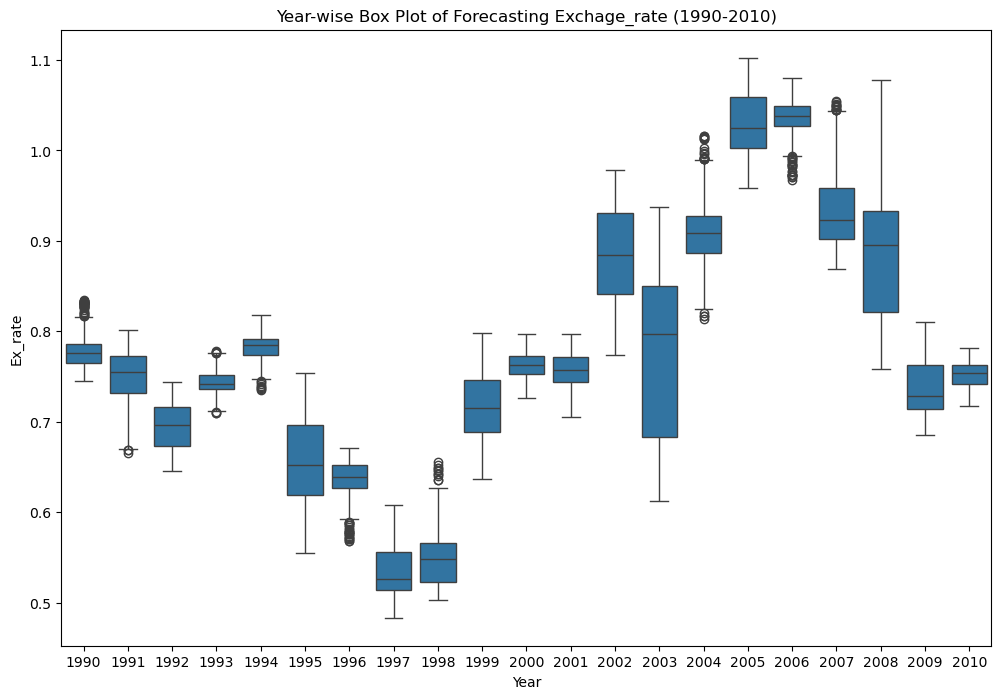

In [222]:
# Create a box plot using seaborn(Year)
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.boxplot(x='year', y='Ex_rate', data=df)
plt.xlabel('Year')
plt.ylabel('Ex_rate')
plt.title('Year-wise Box Plot of Forecasting Exchage_rate (1990-2010)')
plt.show()


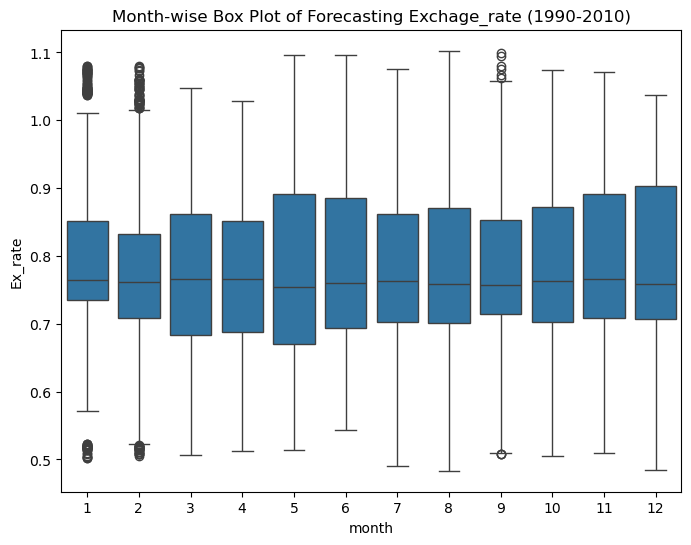

In [223]:
# Create a box plot using seaborn(Month)

plt.figure(figsize=(8, 6))
sns.boxplot(x='month', y='Ex_rate', data=df)
plt.xlabel('month')
plt.ylabel('Ex_rate')
plt.title('Month-wise Box Plot of Forecasting Exchage_rate (1990-2010)')
plt.show()


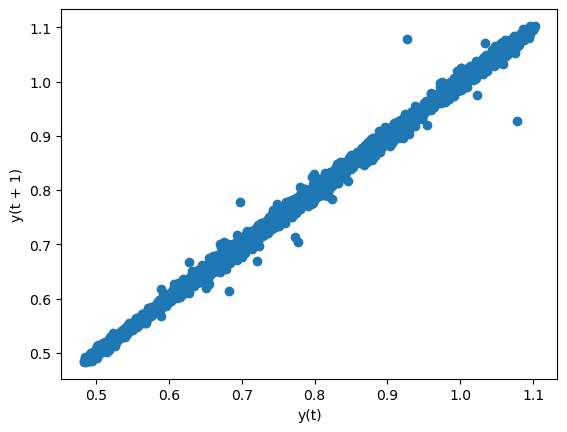

In [224]:
# create a scatter plot
from pandas.plotting import lag_plot
lag_plot(df["Ex_rate"])
plt.show()


<Figure size 4000x1000 with 0 Axes>

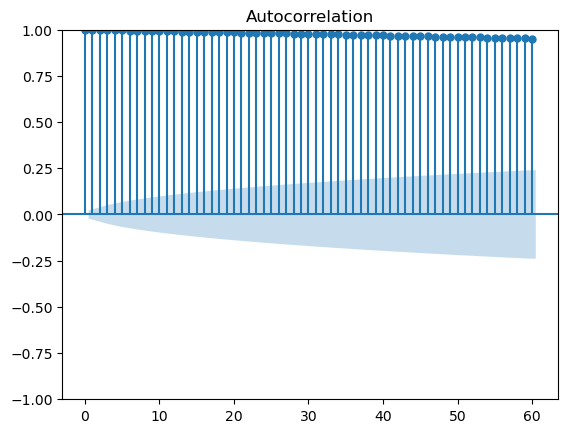

In [225]:
# create an autocorrelation plot for Ex_rate

plt.figure(figsize = (40,10))
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df["Ex_rate"],lags=60)
plt.show()

In [226]:
#ADFULLER(to check whether it is stationary or non-stationary)

adf_result = adfuller(df['Ex_rate'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
if 0.44923273535979974 < 0.05:
    print("Stationary")
else:
    print("Non-Stationary-difference required")

ADF Statistic: -1.6649941807381343
p-value: 0.44923273535979974
Non-Stationary-difference required


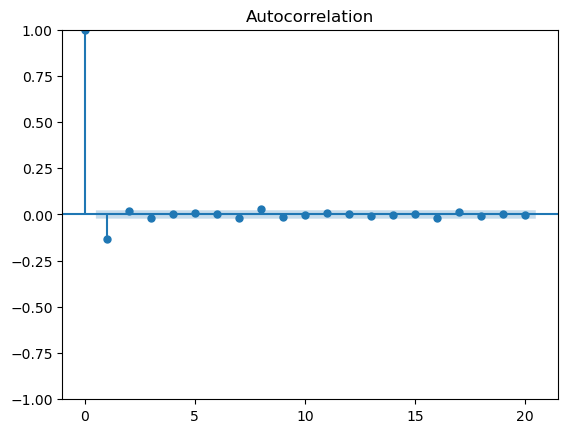

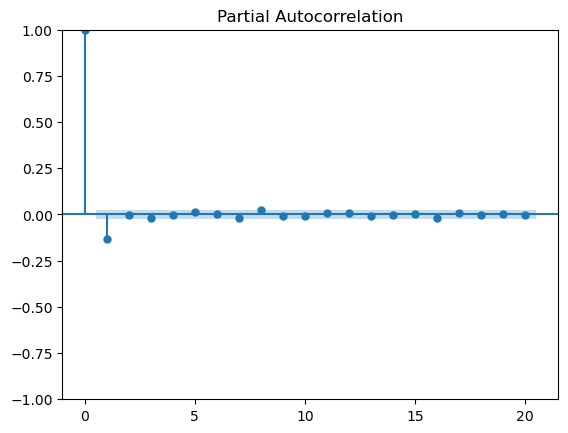

In [227]:
#Difference the series
df['Ex_rate_diff'] = df['Ex_rate'].diff().dropna()

#Plot ACF & PACF(based on difference)

plot_acf(df['Ex_rate_diff'].dropna(), lags=20)
plt.show()

plot_pacf(df['Ex_rate_diff'].dropna(), lags=20)
plt.show()


Example interpretation:

  *PACF cuts off after lag 2 → p = 2

  *ACF cuts off after lag 1 → q = 1

->Initial ARIMA order = (2, 1, 1)

In [228]:
#First fit an AR (AutoRegressive) Model!

#Fit AR Model
# (p=1, d=0, q=0) -> AR(1) model

ar_model = ARIMA(df['Ex_rate'], order=(1,0,0))
ar_model_fit = ar_model.fit()

# Summary of AR model
ar_summary = ar_model_fit.summary()

print("AIC: ",ar_model_fit.aic)
print("BIC: ",ar_model_fit.bic)

# Calculate RMSE using the fitted values and original data
from sklearn.metrics import mean_squared_error
import numpy as np
rmse = np.sqrt(mean_squared_error(df['Ex_rate'], ar_model_fit.fittedvalues))
print("RMSE:",rmse)

AIC:  -55975.96069170833
BIC:  -55955.157721715164
RMSE: 0.006047758223700035


In [229]:
#Fit MA Model
# (p=0, d=0, q=1) -> MA(1) model

ma_model = ARIMA(df['Ex_rate'], order=(0,0,1))
ma_model_fit = ma_model.fit()

# Summary of MA model
ma_summary = ma_model_fit.summary()

#MA Model (ARIMA(0,0,1)) Fitting Summary:

print("AIC: ",ma_model_fit.aic)
print("BIC: ",ma_model_fit.bic)

# Calculate RMSE using the fitted values and original data
from sklearn.metrics import mean_squared_error
import numpy as np
rmse = np.sqrt(mean_squared_error(df['Ex_rate'], ma_model_fit.fittedvalues))
print("RMSE:",rmse)


AIC:  -18651.98014397149
BIC:  -18631.177173978325
RMSE: 0.0707534292191366


In [230]:
#Fit ARIMA Model
# (p=1, d=1, q=1) -> ARIMA(1,1,1) model

arima_model = ARIMA(df['Ex_rate'], order=(1,1,1))
arima_model_fit = arima_model.fit()

# Summary of ARIMA model
arima_summary = arima_model_fit.summary()

#ARIMA Model (ARIMA(1,1,1)) Fitting Summary:

# Successfully fitted an AutoRegressive Integrated Moving Average (ARIMA) model.

print("AIC: ",arima_model_fit.aic)
print("BIC: ",arima_model_fit.bic)

# Calculate RMSE using the fitted values and original data
from sklearn.metrics import mean_squared_error
import numpy as np
rmse = np.sqrt(mean_squared_error(df['Ex_rate'], arima_model_fit.fittedvalues))
print("RMSE:",rmse)


AIC:  -56102.32167281933
BIC:  -56081.51909821331
RMSE: 0.010828926684741192


In [231]:
#Model Fitting
model = ARIMA(df['Ex_rate'], order=(2, 1, 2))
model_fit = model.fit()

# Summary of AR model
summary = model_fit.summary()

print("AIC: ",model_fit.aic)
print("BIC: ",model_fit.bic)

# Calculate RMSE using the fitted values and original data

rmse = np.sqrt(mean_squared_error(df['Ex_rate'], model_fit.fittedvalues))
print("RMSE:",rmse)


AIC:  -56100.13532997609
BIC:  -56065.4643722994
RMSE: 0.010828529798047718


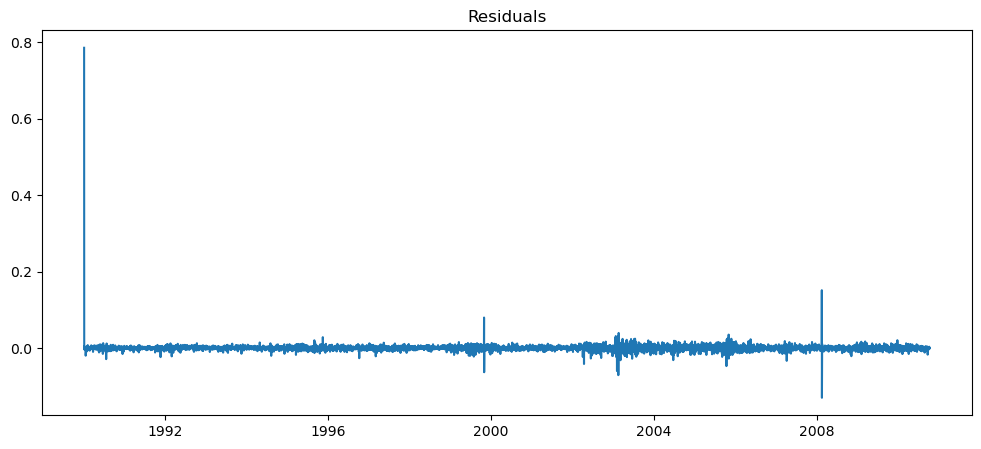

In [232]:
#Residual plots
residuals = model_fit.resid

plt.figure(figsize=(12,5))
plt.plot(residuals)
plt.title("Residuals")
plt.show()


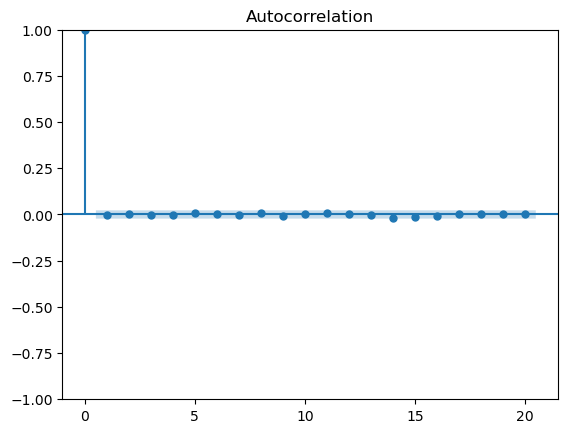

In [233]:
#ACF of residuals
plot_acf(residuals.dropna(), lags=20)
plt.show()


In [248]:
#Forecasting & Visualization
from sklearn.metrics import mean_absolute_error, mean_squared_error

#Train–Test split
train = df['Ex_rate'][:-30]
test = df['Ex_rate'][-30:]

#Refit model on training data
model = ARIMA(train, order=(2,1,1))
model_fit = model.fit()

print("AIC: ",model_fit.aic)
print("BIC: ",model_fit.bic)

#Forecast
forecast = model_fit.forecast(steps=30)

# Actual values
actual = df['Ex_rate'][-30:]

# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(actual, forecast))
print("RMSE:", rmse)

#Mean Absolute Error
mae = mean_absolute_error(actual, forecast)
print("MAE: ",mae)

#Mean Absolute Percantage Error
mape = np.mean(np.abs((actual - forecast) / actual)) * 100
print("MAPE: ",mape)

AIC:  -55860.93556116143
BIC:  -55833.214642901345
RMSE: 0.016633229931121013
MAE:  0.013494929505953938
MAPE:  1.8632687400724866


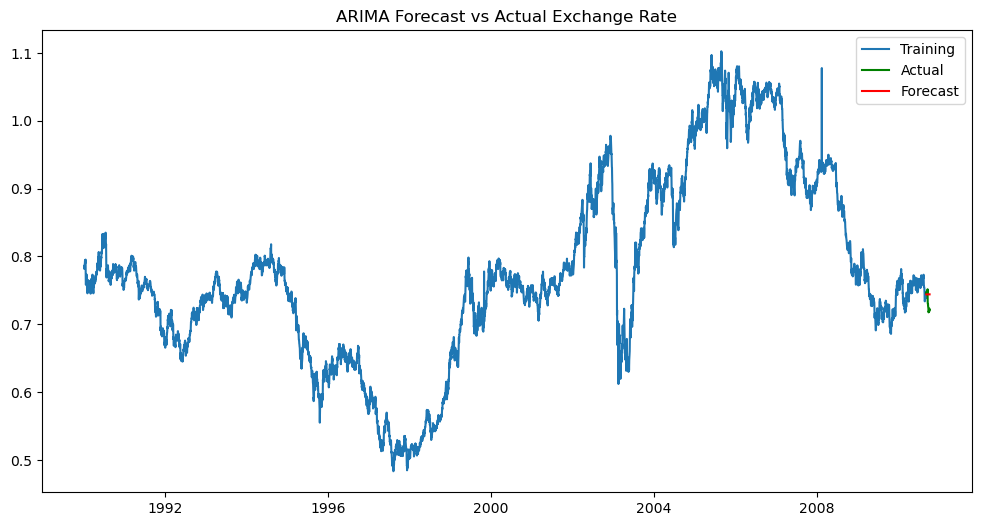

In [244]:
#Plot actual vs forecast
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training')
plt.plot(test.index, test, label='Actual', color='green')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title("ARIMA Forecast vs Actual Exchange Rate")
plt.show()


ARIMA(1,1,1)
   
Advantages of ARIMA(1,1,1):
  *Simple and interpretable
  *Parameters have clear statistical meaning
  *Handles non-stationary data
  *Differencing (d = 1) removes trend components
  *Uses immediate past value and error term
  *Requires relatively small datasets
  *Effective when data is limited

Disadvantages of ARIMA(1,1,1)
  *Limited memory
  *Assumes linear relationships
  *Poor performance if data structure is more complex
  *No seasonal modeling
  *Cannot capture seasonal effects without SARIMA

Limitations of ARIMA(1,1,1)
  *Not suitable for long-term forecasting
  *Poor performance during volatility
  *Ignores external variables
  *Requires stationarity
  *Homoscedasticity assumption
  *Does not handle changing variance well (common in finance)

In [ ]:
ARIMA(2,1,1):
  1. p = 2 → two autoregressive terms
  2. d = 1 → first differencing to achieve stationarity
  3. q = 1 → one moving-average term

Advantages of ARIMA(2,1,1)
  1.Captures short-term dependencies
     Uses two lagged values and one error term
     Effective for exchange rate time series
  2.Handles non-stationary data
     Differencing (d=1) removes trends
  3.Interpretable parameters
     Clear statistical meaning of AR and MA terms
  4.Strong baseline model
     Often outperforms naive forecasting methods
 5.Works well with limited data
     Does not require large datasets like ML models

Disadvantages of ARIMA(2,1,1)
  1.Assumes linear relationships
     Cannot capture nonlinear patterns common in financial markets
  2.Sensitive to parameter selection
     Incorrect p or q can degrade performance
  3.No seasonal modeling
     Cannot capture seasonality without SARIMA extension
  4.Short-term forecasting only
     Accuracy decreases for long-horizon forecasts

Limitations of ARIMA(2,1,1)
  *Ignores external factors
  *Poor during sudden shocks
  *Financial data often violate constant variance assumption
  *Requires stationarity
  *Multiple differencing can lead to information loss

In [ ]:
ARIMA(1,1,1) → simpler, more stable

ARIMA(2,1,1) → captures more structure but higher complexity

    ARIMA(1,1,1) is well suited as a baseline model due to its simplicity and robustness, while ARIMA(2,1,1) is preferable when the data exhibits 
stronger short-term autocorrelation and sufficient historical information is available.